# Building Production Query Classifiers for RAG Systems

> **Series Overview**: This is the final notebook in our three-part series on systematically analyzing and improving RAG systems. We've discovered patterns and improved clustering—now we'll build production-ready classifiers to act on these insights.

> **Prerequisites**: Complete both "1. Cluster Conversations" and "2. Better Summaries" notebooks first. You'll need `instructor` and `instructor_classify` libraries installed, plus the labeled dataset from our clustering analysis.

## Why This Matters

**Discovery without action is just interesting data.** In our previous notebooks, we systematically analyzed 560 user queries and uncovered clear patterns through improved clustering. We know that three major themes—experiment management, artifact handling, and deployment—account for the majority of user questions. But knowing patterns exist in historical data isn't enough.

**To transform insights into improvements, we need real-time classification.** Specifically, we need to:

1. **Detect Production Drift** - Identify when certain query types suddenly increase, signaling emerging issues
2. **Route Queries Intelligently** - Direct questions to specialized retrieval pipelines based on their category
3. **Prioritize Improvements** - Focus engineering resources on high-volume, low-satisfaction query types
4. **Measure Impact** - Track how changes affect different user segments over time

**Classification bridges the gap between discovery and action**, transforming our topic modeling insights into a production-ready system for continuous RAG improvement.

## What You'll Learn

In this final notebook, you'll discover how to:

1. **Create Production-Ready Classifiers**
   - Build efficient classifiers using the `instructor-classify` framework
   - Generate weak labels automatically for rapid dataset creation
   - Design systematic workflows for human label verification

2. **Achieve High Classification Accuracy**
   - Start with baseline performance and iterate systematically
   - Apply advanced prompting techniques (system prompts, few-shot examples)
   - Measure and visualize improvements using confusion matrices

3. **Scale Classification to Full Datasets**
   - Apply optimized classifiers to thousands of queries efficiently
   - Understand true query distributions across your user base
   - Identify high-impact areas for targeted RAG improvements

## What You'll Achieve

**By the end of this notebook, you'll have built a classifier that achieves 90.9% accuracy**—improving from a 72.7% baseline through systematic prompt engineering. You'll discover that just three categories (artifacts, integrations, visualizations) account for 50% of all user conversations, giving you clear targets for maximum impact improvements.

**More importantly, you'll have a complete methodology for continuous RAG improvement**: discover patterns through clustering → validate with better summaries → monitor continuously through classification → prioritize improvements based on real usage data.

## From Reactive to Proactive RAG Systems

**Most RAG systems improve reactively**—waiting for user complaints or noticing obvious failures. **This series shows you how to build proactively improving systems** that identify problems before users complain and prioritize fixes based on systematic analysis rather than the loudest feedback.

By the end of this notebook, you'll have moved from "we think users struggle with X" to "we know 20% of users need help with artifacts, 15% with integrations, and 14% with visualizations—and we can automatically detect and route these queries for specialized handling."

## What You'll Learn

In this notebook, you'll discover how to:

1. **Generate Weak Labels and Create a Golden Dataset**
   - Create an initial classifier using the instructor-classify framework
   - Generate preliminary labels for your conversation dataset
   - Use app.py to review and correct weak labels for a high-quality labeled dataset

2. **Iteratively Improve Classification Accuracy**
   - Start with a simple baseline classifier
   - Enhance performance with few-shot examples and system prompts
   - Measure improvements using confusion matrices and accuracy metrics

3. **Analyze Query Distribution in Your Dataset**
   - Apply your optimized classifier to the full dataset
   - Understand the prevalence of different query types
   - Identify high-impact areas for RAG system improvements

Rather than trying to replicate all the nuanced clusters from our topic modeling, we'll focus on three high-impact categories that emerged from our analysis:

1. Artifacts - Questions about creating, versioning, and managing W&B artifacts
2. Integrations - Questions about integrating W&B with specific libraries and frameworks
3. Visualisations - Questions about creating charts, dashboards, and visual analysis
4. Other - General queries that don't fit the specialized categories above

By the end of this notebook, you'll have moved from "we discovered these patterns exist" to "we can automatically detect and act on these patterns in production."

## Defining Our Classifier

Our topic modeling revealed several distinct clusters of user queries, with three major topics accounting for the majority of questions:

1. Users seeking help with experiment tracking and metrics logging
2. Users trying to manage artifacts and data versioning
3. Users needing assistance with integrations and deployment

In this notebook, we'll show how we might build a classifier which can identify queries related to creating, managing and versioning weights and biases artifacts, questions about integrations as well as visualisations of data that's been logged.

1. First we'll define a simple classifier using `instructor-classify` that will take in a query and document pair and output a suggested category for it 
2. Then we'll see a few examples of the `instructor-classify` library in action
3. Lastly, we'll then generate a set of initial weak labels using this simple classifier before exporting it to a file for manual annotation using our `app.py` file.

Let's get started with the `instructor-classify` library

In [41]:
from instructor_classify.schema import LabelDefinition, ClassificationDefinition

artifact_label = LabelDefinition(
    label="artifact",
    description="This is a user query and document pair which is about creating, versioning and managing weights and biases artifacts.",
)

integrations_label = LabelDefinition(
    label="integrations",
    description="this is a user query and document pair which is concerned with how we can integrate weights and biases with specific libraries",
)

visualisation_label = LabelDefinition(
    label="visualisation",
    description="This is a user query and document pair which is concerned about how we can visualise the data that we've logged with weights and biases",
)

other_label = LabelDefinition(
    label="other",
    description="Use this label for other query types which don't belong to any of the other defined categories that you have been provided with",
)


classification_def = ClassificationDefinition(
    system_message="You're an expert at classifying a user and document pair. Look closely at the user query and determine what the query is about and how the document helps answer it. Then classify it according to the label(s) above. Classify irrelevant ones as Other",
    label_definitions=[
        artifact_label,
        other_label,
        visualisation_label,
        integrations_label,
    ],
)

This structure makes it easy to define multiple categories in a way that's clear to both humans and LLMs. It provides explicit definitions of what each category means, making it easier for the model to make accurate predictions.

We also support exporing this configuration to a `.yaml` format for easy use if you're working with domain experts for easy collaboration.

### A Simple Example

Let's now see how `instructor-classify` works under the hood. We'll do so by passing in 4 sample queries and seeing how our classifier is able to deal with these test cases

In [137]:
import instructor
from instructor_classify.classify import Classifier
from openai import OpenAI

client = instructor.from_openai(OpenAI())
classifier = (
    Classifier(classification_def).with_client(client).with_model("gpt-4.1-mini")
)

# Make a prediction
result = classifier.predict("How do I version a weights and biases artifact?")
print(f"Classification: {result}")  # Should output "artifact";

result_2 = classifier.predict("What is the square root of 9?")
print(f"Classification: {result_2}")  # Should output "not_artifact"

Classification: label='artifact'
Classification: label='other'


`instructor-classify` exposes a `batch_predict` function which parallelises this operation for us so that we can run evaluations efficiently over large datasets. Let's see it in action below with some test cases


In [139]:
tests = [
    "How do I version a weights and biases artifact?",
    "What is the square root of 9?",
    "How do I integrate weights and biases with pytorch?",
    "What are some best practices when using wandb?",
    "How can I visualise my training runs?",
]

labels = ["artifact", "other", "integrations", "other", "visualisation"]

results = classifier.batch_predict(tests)
for query, result, label in zip(tests, results, labels):
    print(f"Query: {query}\nClassification: {result}\nExpected: {label}\n")

classify:   0%|          | 0/5 [00:00<?, ?it/s]

Query: How do I version a weights and biases artifact?
Classification: label='artifact'
Expected: artifact

Query: What is the square root of 9?
Classification: label='other'
Expected: other

Query: How do I integrate weights and biases with pytorch?
Classification: label='integrations'
Expected: integrations

Query: What are some best practices when using wandb?
Classification: label='other'
Expected: other

Query: How can I visualise my training runs?
Classification: label='visualisation'
Expected: visualisation



### Creating Weak Labels

What is a weak label? A weak label is an automatically generated label that might be incorrect, but is "good enough" to start with. Think of it like a rough first draft - it gives you a starting point that you can then review and correct.

In real-world RAG systems, manually labeling thousands of queries is prohibitively time-consuming. Instead of having humans label every single query from scratch, weak labeling lets us use an AI classifier to do the initial work. 

Here's how it works:

1. Our classifier automatically assigns labels to hundreds of queries in minutes
2. We review these "weak labels" and ask annotators to simply accept/reject the labels
3. This allows us to create gold label datasets much faster and efficiently that we would be able to do so manually.

This approach has several key advantages:

1. Speed: We can process hundreds or thousands of examples in minutes rather than hours
2. Consistency: The classifier applies the same criteria across all examples
3. Scalability: The process can be applied to continuously growing datasets

The process follows a virtuous cycle: our classifier generates weak labels → humans verify a subset → verified labels improve the classifier → better classifier generates more accurate weak labels. 

To help you try this, we've created a simple UI using streamlit where we can then either approve or reject these labels. You can run this at `streamlit run app.py`.

In [11]:
import json

with open("./data/conversations.json") as f:
    conversations_raw = json.load(f)

texts = [
    {
        "query": item["query"],
        "matching_document": item["matching_document"],
        "query_id": item["query_id"],
    }
    for item in conversations_raw
]

results = classifier.batch_predict(texts[:110])

In [13]:
with open("./data/generated.jsonl", "w+") as f:
    for item, result in zip(conversations_raw, results):
        f.write(
            json.dumps(
                {
                    "query": item["query"],
                    "matching_document": item["matching_document"],
                    "query_id": item["query_id"],
                    "labels": result.label,
                }
            )
            + "\n"
        )

## Evaluating Our Classifier

We've labelled a dataset of ~100 items our of our 560 conversations ahead of time. If you'd like to label more datasets, we've provided an `app.py` file which you can run using the command `streamlit run app.py`.

We'll be splitting this into a test and validation split. We'll be using the `validation` split to iterate on our prompt and experiment with different few shot examples before using the `test` split to validate our classifier's performance. 

We'll be using a 70-30 split with 70% of our data used for validation and 30% used for testing our final classifier. 

In [140]:
import json
import random

with open("./data/labels.jsonl") as f:
    conversations_labels = [json.loads(line) for line in f]

# Set random seed for reproducibility
random.seed(42)

# Shuffle the data
random.shuffle(conversations_labels)

# Calculate split index
split_idx = int(len(conversations_labels) * 0.7)

# Split into validation and test sets
val_set = conversations_labels[:split_idx]
test_set = conversations_labels[split_idx:]

print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")

Validation set size: 77
Test set size: 33


### Determining a baseline

Let's now calculate a baseline and see how well our initial classification model performs.

In [141]:
val_text = [
    f"bQuery: {item['query']}\n Retrieved Document: {item['matching_document']}"
    for item in val_set
]
val_labels = [item["labels"] for item in val_set]

test_text = [
    f"Query: {item['query']}\n Retrieved Document: {item['matching_document']}"
    for item in test_set
]
test_labels = [item["labels"] for item in test_set]

Let's now define a function which runs the classifier on the validation set and the test set to see our initial starting point. We'll look at some of the failure cases and then iterately improve our classifier.

In [142]:
from sklearn.metrics import confusion_matrix
from instructor_classify.classify import Classifier


def predict_and_evaluate(classifier: Classifier, texts: list[str], labels: list[str]):
    predictions = classifier.batch_predict(texts)
    pred_labels = [p.label for p in predictions]

    return {
        "accuracy": sum(pred == label for pred, label in zip(pred_labels, labels))
        / len(predictions),
        "queries": texts,
        "labels": labels,
        "predictions": pred_labels,
    }


classifier = (
    Classifier(classification_def).with_client(client).with_model("gpt-4.1-mini")
)
predictions = predict_and_evaluate(classifier, val_text, val_labels)
predictions["accuracy"]

0.7272727272727273

<Figure size 1000x800 with 0 Axes>

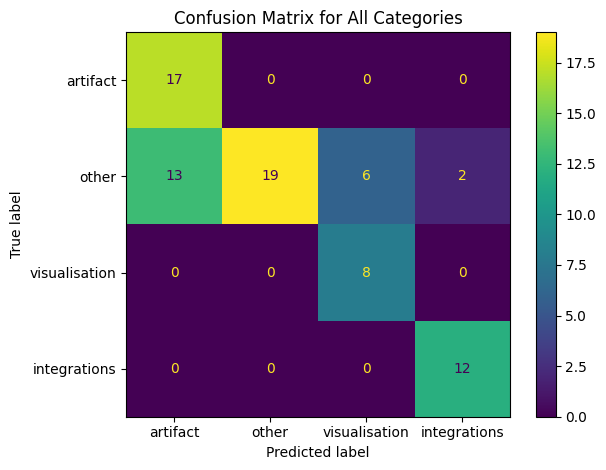

In [143]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Get unique labels
unique_labels = ["artifact", "other", "visualisation", "integrations"]

# Convert predictions and true labels to label indices
y_true = [unique_labels.index(label) for label in predictions["labels"]]
y_pred = [unique_labels.index(label) for label in predictions["predictions"]]

# Calculate single confusion matrix for all categories
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, display_labels=unique_labels
)
disp.plot()
plt.title("Confusion Matrix for All Categories")
plt.tight_layout()
plt.show()

Let's now see how it looks like when we run it on our test set

In [144]:
test_predictions = predict_and_evaluate(classifier, test_text, test_labels)
test_predictions["accuracy"]

0.696969696969697

<Figure size 1000x800 with 0 Axes>

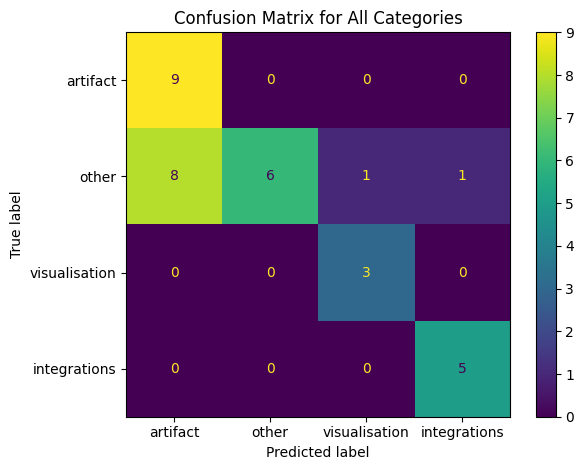

In [145]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Get unique labels
unique_labels = ["artifact", "other", "visualisation", "integrations"]

# Convert predictions and true labels to label indices
y_true = [unique_labels.index(label) for label in test_predictions["labels"]]
y_pred = [unique_labels.index(label) for label in test_predictions["predictions"]]

# Calculate single confusion matrix for all categories
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, display_labels=unique_labels
)
disp.plot()
plt.title("Confusion Matrix for All Categories")
plt.tight_layout()
plt.show()

### Looking at Edge Cases

Let's now print out some of the errors that our model made in classifying our user queries

In [146]:
for prediction, label, query in zip(
    test_predictions["predictions"],
    test_predictions["labels"],
    test_predictions["queries"],
):
    if label != prediction:
        print(f"Label: {label}")
        print(f"Prediction: {prediction}")
        print(f"Query: {query}")
        print("=====")

Label: other
Prediction: artifact
Query: Query: machine learning model tracking
 Retrieved Document: ## Track a model

Track a model, the model's dependencies, and other information relevant to that model with the W&B Python SDK.  

Under the hood, W&B creates a lineage of model artifact that you can view with the W&B App UI or programmatically with the W&B Python SDK. See the Create model lineage map for more information.  

## How to log a model  

Use the `run.log_model` API to log a model. Provide the path where your model files are saved to the `path` parameter. The path can be a local file, directory, or reference URI to an external bucket such as `s3://bucket/path`.  

Optionally provide a name for the model artifact for the `name` parameter. If `name` is not specified, W&B uses the basename of the input path prepended with the run ID.  

Copy and paste the proceeding code snippet. Ensure to replace values enclosed in `<>` with your own.
=====
Label: other
Prediction: artifact
Q

When exmaining our confusion matrices in detail, we observe a consistent pattern of misclassification in the "other" category where our classifier frequently misidentifies these queries by assigning them to one of our specific categories.

Looking at the classification errors, we can identify several patterns

1. `Context Confusion` : The model tends to ignore the user's specific question but instead gets confused by the retrieved document. If a document contains specific bits of information about an artifact, even if the user's question is simply a general question.
2. `Over-Eagerness` : The model tends to prefer assigning specialised categories rathern than the more general "other" category, even when evidence is limited. This results in false positives for our specialised categories.

To address these issues, we'll need to carefully craft our prompts to help the model better distinguish between general W&B functionality and specific feature categories. 

By combining improved system prompts with strategically selected few-shot examples, we can guide the model to pay closer attention to the user's actual intent rather than being misled by terminology in the retrieved documents. 

Our next steps will focus on implementing these improvements and measuring their impact on classification accuracy, particularly for the challenging "other" category where most of our errors occur.

## Improving Our Classifier

Our baseline classifier achieved approximately 73% accuracy on the validation set, but the confusion matrices revealed significant challenges with the "other" category. 

To address these issues, we'll take a systematic approach to enhancement:

1. Refining system prompts to provide clearer boundaries between categories and explicitly instruct the model on how to handle ambiguous cases
2. Adding few-shot examples that demonstrate the correct handling of edge cases, particularly for general queries that mention specialized terms

Let's get started and see how to do so.

### System Prompt

The first improvement we'll implement is a more precise system prompt. Our error analysis showed that the model frequently misclassifies general queries as specialized categories when the retrieved document mentions features like artifacts or visualisations.

By providing explicit instructions about how to prioritize the user's query over the retrieved document and establishing clearer category boundaries, we can help the model make more accurate distinctions. We'll also provide a clear description of what each category represents so taht the model can make more accurate distinctions.

In [48]:
import instructor
from instructor_classify.classify import Classifier
from instructor_classify.schema import LabelDefinition, ClassificationDefinition
from openai import OpenAI

client = instructor.from_openai(OpenAI())

artifact_label = LabelDefinition(
    label="artifact",
    description="This is a user query and document pair which is about creating, versioning and managing weights and biases artifacts.",
)

integrations_label = LabelDefinition(
    label="integrations",
    description="this is a user query and document pair which is concerned with how we can integrate weights and biases with specific libraries",
)

visualisation_label = LabelDefinition(
    label="visualisation",
    description="This is a user query and document pair which is concerned about how we can visualise the data that we've logged with weights and biases",
)

other_label = LabelDefinition(
    label="other",
    description="Use this label for other query types which don't belong to any of the other defined categories that you have been provided with",
)


classification_def_w_system_prompt = ClassificationDefinition(
    system_message="""
You are a world class classifier. You are given a user query and a document. 

Look closely at the user query and determine what the user's query is about. You will also be provided with a document which is relevant to the user's query. It might contain additional information that's not relevant to the user's query so when deciding on the category, only consider the parts that are relevant to answering the user's specific question.

Here are the categories you can choose from:

1. Artifacts - questions about creating, versioning and managing weights and biases artifacts. Note that in W&B there are two ways to store data - Artifacts and Files. Only consider queries about artifacts when they explicitly mention the usage of Artifacts with W&B.
2. Integrations - questions about integrating weights and biases with specific libraries. 
3. Visualisation - questions about visualising the data that we've logged with weights and biases
4. Other - queries that don't fit the above categories

Choose a single category for the user query and document pair that's the best match""",
    label_definitions=[
        artifact_label,
        other_label,
        visualisation_label,
        integrations_label,
    ],
)

In [49]:
client = instructor.from_openai(OpenAI())
classifier_v2 = (
    Classifier(classification_def_w_system_prompt)
    .with_client(client)
    .with_model("gpt-4.1-mini")
)

In [51]:
predictions_system_prompt = predict_and_evaluate(classifier_v2, val_text, val_labels)
predictions_system_prompt["accuracy"]

0.8051948051948052

Let's now see how our model performs by using a confusion matrix

<Figure size 1000x800 with 0 Axes>

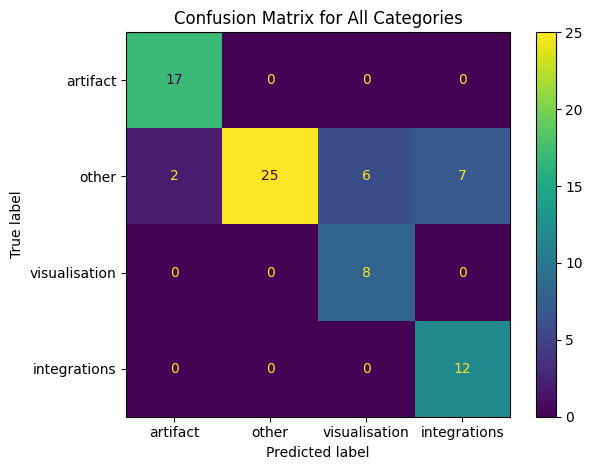

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Get unique labels
unique_labels = ["artifact", "other", "visualisation", "integrations"]

# Convert predictions and true labels to label indices
y_true = [unique_labels.index(label) for label in predictions_system_prompt["labels"]]
y_pred = [
    unique_labels.index(label) for label in predictions_system_prompt["predictions"]
]

# Calculate single confusion matrix for all categories
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, display_labels=unique_labels
)
disp.plot()
plt.title("Confusion Matrix for All Categories")
plt.tight_layout()
plt.show()

It seems that with this new prompt, we've seen a roughly 16% improvement in our accuracy. One major issue seems to be classifying queries as the `other` category well. Let's visualise some of these queries

In [53]:
for prediction, label, query in zip(
    predictions_system_prompt["predictions"],
    predictions_system_prompt["labels"],
    predictions_system_prompt["queries"],
):
    if label != prediction:
        print(f"Label: {label}")
        print(f"Prediction: {prediction}")
        print(f"Query: {query}")
        print("=====")

Label: other
Prediction: visualisation
Query: Query: Examples of logging images in Wandb
 Retrieved Document: ## Log Media & Objects
### Images
```
images = wandb.Image(image\_array, caption="Top: Output, Bottom: Input")

wandb.log({"examples": images})

```  

We assume the image is gray scale if the last dimension is 1, RGB if it's 3, and RGBA if it's 4. If the array contains floats, we convert them to integers between `0` and `255`. If you want to normalize your images differently, you can specify the `mode` manually or just supply a `PIL.Image`, as described in the "Logging PIL Images" tab of this panel.  

For full control over the conversion of arrays to images, construct the `PIL.Image` yourself and provide it directly.  

```
images = [PIL.Image.fromarray(image) for image in image\_array]

wandb.log({"examples": [wandb.Image(image) for image in images]})

```  

For even more control, create images however you like, save them to disk, and provide a filepath.  

```
im = PIL.fro

### Few Shot Examples

Building on our improved system prompt, we'll now add few-shot examples to our classifier. Few-shot examples provide concrete demonstrations of how to handle tricky edge cases, teaching the model through specific instances rather than abstract rules. This approach is particularly effective for resolving the context confusion and over-eagerness issues we identified in our error analysis.


For each label category, we've carefully selected examples that illustrate:
- Clear positive cases that should be assigned to that category
- Negative cases that might seem related but actually belong elsewhere

An example is when we show queries which were previously classified as integrations (Eg. using AWS IAM ) as others since these are authorization related.

In [120]:
import instructor
from instructor_classify.schema import (
    LabelDefinition,
    ClassificationDefinition,
    Examples,
)
from openai import OpenAI

client = instructor.from_openai(OpenAI())

artifact_label = LabelDefinition(
    label="artifact",
    description="This is a user query and document pair which is about creating, versioning and managing weights and biases artifacts.",
    examples=Examples(
        examples_positive=[
            "How do I version a weights and biases artifact?",
        ],
        examples_negative=[
            "How do I do log an image with weights and biases?",
        ],
    ),
)
integrations_label = LabelDefinition(
    label="integrations",
    description="this is a user query and document pair which is concerned with how we can integrate weights and biases with specific libraries. Note that Wandb is the weights and biases sdk's name so all questions about using it specifically will not be an integration question.",
    examples=Examples(
        examples_positive=[
            "How do I use weights and biases with keras?",
        ],
        examples_negative=[
            "how do I do distributed logging and tracing with weights and biases?",
            "what are some common issues that users face when using weights and biases?",
            "Does weights and bias support IAM access control?",
        ],
    ),
)

visualisation_label = LabelDefinition(
    label="visualisation",
    description="This is a user query and document pair which is concerned about how we can visualise the data that we've logged with weights and biases",
    examples=Examples(
        examples_positive=[
            "How do I visualise my training runs?",
        ],
        examples_negative=[
            "Does Weights and biases support AWS IAM authentication when using SageMaker?",
        ],
    ),
)

other_label = LabelDefinition(
    label="other",
    description="Use this label for other query types which don't belong to any of the other defined categories that you have been provided with",
    examples=Examples(
        examples_positive=[
            "How do I do a hyper-parameter search with weights and biases?",
            "How do I log an image with weights and biases?",
            "Can I deploy weights and biases in my own infrastructure?",
            "Does weights and bias support IAM access control with sagemaker?",
            "How do I initialise weights and biases?",
        ],
        examples_negative=[
            "How do I save a weights and biases artifact?",
        ],
    ),
)


classification_def_w_system_prompt_and_examples = ClassificationDefinition(
    system_message="""
You are a world class classifier. You are given a user query and a document. 

Look closely at the user query and determine what the user's query is about. You will also be provided with a document which is relevant to the user's query. It might contain additional information that's not relevant to the user's query so when deciding on the category, only consider the parts that are relevant to answering the user's specific question.

Here are the categories you can choose from:

1. Artifacts - questions about creating, versioning and managing weights and biases artifacts. Note that in W&B there are two ways to store data - Artifacts and Files. Only consider queries about artifacts when they explicitly mention the usage of Artifacts with W&B.
2. Integrations - questions about integrating weights and biases with specific libraries. This should only be used for questions about using the weights and biases sdk with specific libraries.
3. Visualisation - questions about visualising the data that we've logged with weights and biases
4. Other - queries that don't fit the above categories. 

Note that in weights and biases there are two ways to store data - Artifacts and Files. Only consider queries about artifacts when they explicitly mention the usage of Artifacts with W&B. Just logging data isn't sufficient to be classified as an artifact, it must explicitly reference or use the Artifact API.

Choose a single category for the user query and document pair that's the best match""",
    label_definitions=[
        artifact_label,
        other_label,
        visualisation_label,
        integrations_label,
    ],
)

In [122]:
classifier_v3 = (
    Classifier(classification_def_w_system_prompt_and_examples)
    .with_client(client)
    .with_model("gpt-4.1-mini")
)
predictions_system_prompt_and_examples = predict_and_evaluate(
    classifier_v3, val_text, val_labels
)
predictions_system_prompt_and_examples["accuracy"]

0.9090909090909091

In [123]:
for prediction, label, query in zip(
    predictions_system_prompt_and_examples["predictions"],
    predictions_system_prompt_and_examples["labels"],
    predictions_system_prompt_and_examples["queries"],
):
    if label != prediction:
        print(f"Label: {label}")
        print(f"Prediction: {prediction}")
        print("## Query")
        print(f"{query}")
        print("=====")

Label: other
Prediction: integrations
## Query
Query: Are there any best practices for using wandb in a distributed training environment?
 Retrieved Document: ## Add wandb to Any Library
#### Distributed Training

For frameworks supporting distributed environments, you can adapt any of the following workflows:  

* Detect which is the “main” process and only use `wandb` there. Any required data coming from other processes must be routed to the main process first. (This workflow is encouraged).
* Call `wandb` in every process and auto-group them by giving them all the same unique `group` name  

See Log Distributed Training Experiments for more details
=====
Label: other
Prediction: visualisation
## Query
Query: Weights & Biases features for LLM developers
 Retrieved Document: **Weights & Biases Prompts** is a suite of LLMOps tools built for the development of LLM-powered applications.  

Use W&B Prompts to visualize and inspect the execution flow of your LLMs, analyze the inputs and ou

<Figure size 1000x800 with 0 Axes>

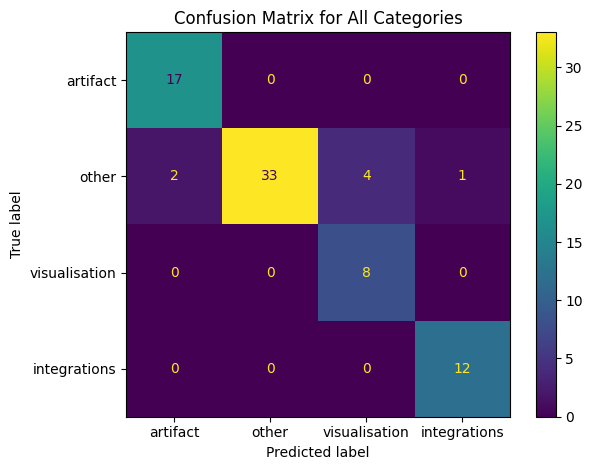

In [124]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Get unique labels
unique_labels = ["artifact", "other", "visualisation", "integrations"]

# Convert predictions and true labels to label indices
y_true = [
    unique_labels.index(label)
    for label in predictions_system_prompt_and_examples["labels"]
]
y_pred = [
    unique_labels.index(label)
    for label in predictions_system_prompt_and_examples["predictions"]
]

# Calculate single confusion matrix for all categories
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, display_labels=unique_labels
)
disp.plot()
plt.title("Confusion Matrix for All Categories")
plt.tight_layout()
plt.show()

Let's now see the performance of this classifier on the test set

In [125]:
predictions_system_prompt_and_examples = predict_and_evaluate(
    classifier_v3, test_text, test_labels
)
predictions_system_prompt_and_examples["accuracy"]

0.9090909090909091

# Performance Evolution: From Baseline to Optimized Classifier

Let's examine how systematic changes to our prompting strategy transformed our classifier's performance:

| Prompt | Baseline | System Only | System + Examples |
|--------|----------|-------------|------------------|
| Accuracy | 72.7% | 80.5% (+10.7%) | 90.9% (+25.0%) |

These improvements demonstrate the power of thoughtful prompt engineering. By adding a clear system prompt, we saw a significant 10.7% relative improvement. When we further enhanced this with carefully selected examples, we achieved an additional 25% gain relative to our baseline, bringing our final validation accuracy to 90.9%.

The real test came with our holdout test set, where we maintained this high performance level - achieving 90.9% accuracy compared to the baseline's 69.7%. This consistency between validation and test performance suggests our improvements are robust and generalizable.



## Application

Now that we've built and validated a classifier with over 90% accuracy, we can confidently apply it to our entire dataset to understand the true distribution of user queries. This isn't just an academic exercise - it's a powerful tool for product development

In [128]:
with open("./data/conversations.json") as f:
    conversations_full = json.load(f)

dataset_texts = [
    f"Query:{item['query']}\nRetrieved Document:{item['matching_document']}"
    for item in conversations_full
]

In [130]:
dataset_labels = classifier_v3.batch_predict(dataset_texts)

In [131]:
from collections import Counter

Counter([item.label for item in dataset_labels])

Counter({'other': 285,
         'artifact': 115,
         'integrations': 83,
         'visualisation': 77})

## Conclusion

### What You Learned

In this final notebook, you learned how to bridge the gap between discovery and production by building robust query classifiers. You discovered how to:

- **Generate weak labels efficiently** using automated classification and human review workflows
- **Build production classifiers** using the `instructor` library with systematic prompt engineering
- **Iteratively improve performance** through enhanced system prompts and few-shot examples
- **Evaluate and measure accuracy** using confusion matrices and validation/test splits
- **Apply classifiers at scale** to understand true query distributions across your dataset

### What We Accomplished

We built a production-ready classifier that achieved 90.9% accuracy through systematic prompt engineering, starting from a 72.7% baseline. Our iterative improvements—adding clear system prompts (+10.7%) and strategic few-shot examples (+25% total)—demonstrated the power of thoughtful prompt design.

Applying our classifier to the full dataset revealed that just three categories—artifacts (20%), integrations (15%), and visualizations (14%)—account for roughly 50% of all user conversations. This concentration is significant because it means we can focus improvement efforts on these specific areas to impact half of all user interactions with measurable precision:

- **Artifacts**: Analyze specific operations users struggle with (versioning, linking, metadata management) to build specialized guides and automated workflows
- **Integrations**: Identify which libraries generate the most questions to create framework-specific tutorials and testing tools  
- **Visualizations**: Understand common visualization needs to build specialized UIs and simpler workflows

More importantly, this systematic approach transforms vague user feedback into actionable product insights, enabling engineering teams to prioritize features, documentation teams to focus efforts, and product teams to make data-driven roadmap decisions.

### Beyond Classification: The Production Frontier

With our classifier successfully identifying query patterns at 90%+ accuracy, you've built the foundation for advanced RAG improvements that extend far beyond this tutorial series:

- **Specialized Retrieval Pipelines**: Build dedicated embedding models and retrieval strategies optimized for each category
- **Proactive Monitoring**: Detect when artifact queries surge, signaling potential documentation gaps or product issues
- **Intelligent Query Routing**: Automatically direct integration questions to framework-specific knowledge bases or expert systems
- **Closed-loop Feedback**: Measure which query types have the lowest satisfaction scores to prioritize improvements

The key insight from this entire series is that improving RAG systems isn't about better models or more data—it's about understanding your users systematically and building focused solutions for their actual needs. This methodology can be applied to any domain where you have query-document pairs and want to move from reactive fixes to proactive, data-driven improvements.